# Análisis de Género

## Carga de paquetes

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Números y Datos
import pandas as pd
import numpy as np

# Clustering (sklearn)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

from sklearn.neighbors import NearestNeighbors


from sklearn.metrics import confusion_matrix

## Carga de configuraciones

In [17]:
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# Set seed for random generation
seed = 3569
np.random.seed(seed)

genre_config = {
    'jazz': 1,
    'classical' : 2,
    'drum-and-bass' : 3,
    'death-metal' : 4,
    'ambient' : 5,
    'ska' : 6,
    'singer-songwriter' : 7,
    'opera' : 8,
    'trance' : 9
}

## Carga de dataset

In [18]:
df_spotify = pd.read_pickle('../sources/df_todo_1_Normalized.pickle')

## Selecciono features a utilizar

In [19]:
features_af = ['danceability','energy','loudness','speechiness','acousticness','acousticness','valence']
features_af_otras= ['duration_ms','tempo','time_signature']
features_aa = ['p00_C_50','p01_C#_50','p02_D_50','p03_D#_50','p04_E_50','p05_F_50']

In [20]:
genre_real = df_spotify['genre']
genre_numeric = [genre_config[item] for item in genre_real]

## Genero Matriz de Confusión

In [21]:
def plot_conf_matrix(real, Z2, xlabels, description):
    mat = confusion_matrix(real, Z2)
    sns.heatmap(
        mat.T,
        square=True,
        annot=True,
        fmt='d',
        cbar=False,
        xticklabels=xlabels,
        yticklabels=range(9)
    )
    plt.xlabel('Real')
    plt.ylabel(description)
    plt.show()

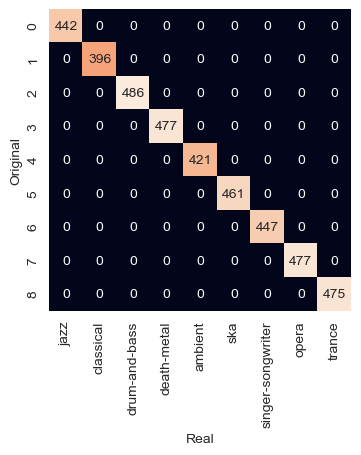

In [22]:
genres = genre_real.unique()

plot_conf_matrix(
    genre_real.values,
    genre_real.values,
    genres,
    'Original'
)

# Tendencia al clustering (Hopkins)

In [23]:
def Hopkins(df,*args):
    n = df.shape[0] # filas
    d = df.shape[1] # columnas
    if not args:
        print("Numero de puntos al azar por defecto")
        m = int(0.1 * n) # cantidad de puntos al azar (default)
    else:
        m = args[0] # cantidad de puntos al azar

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df) # buscador de vecinos

    rand_ind = random.sample(range(0, n, 1), m) # indices al azar

    ui = []
    wi = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
        ui.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
        wi.append(w_dist[0][1])

    H = sum(wi) / (sum(ui) + sum(wi))
    return H

In [24]:
df = df_spotify.drop(['genre'], axis=1)
df=scaler.fit_transform(df)
Hopkins(df)

Numero de puntos al azar por defecto


0.06520232498172975

## Efecto Uniforme

In [25]:
clusters = df_spotify.genre.value_counts()
print(np.std(clusters)/np.mean(clusters))

0.06243141865809519


## Validación Interna

In [26]:
from sklearn.metrics.pairwise import euclidean_distances

df = df_spotify.drop(['genre'], axis=1)
d  = euclidean_distances(df, df)

## Dendogramas y matriz de Correlacion

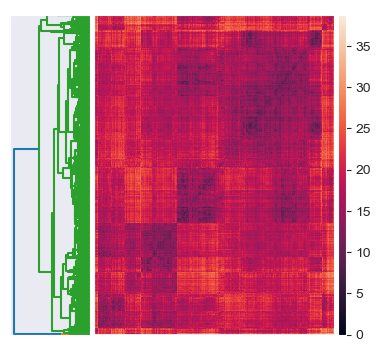

In [27]:
import pylab
from scipy.cluster.hierarchy import dendrogram, linkage

# Abrir figura nueva
fig = pylab.figure()

# Calcular dendrograma y graficar.
axdendro = fig.add_axes([0.09,0.1,0.2,0.8])
Y = linkage(d, method='centroid')
Z = dendrogram(Y, orientation='right')
axdendro.set_xticks([])
axdendro.set_yticks([])
axdendro.invert_xaxis()

# Graficar la matriz de distancias.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.8])
index = Z['leaves']
d = d[index,:]
d = d[:,index]
im = axmatrix.matshow(d, aspect='auto', origin='lower')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Graficar la barra de color
axcolor = fig.add_axes([0.91,0.1,0.02,0.8])
pylab.colorbar(im, cax=axcolor)

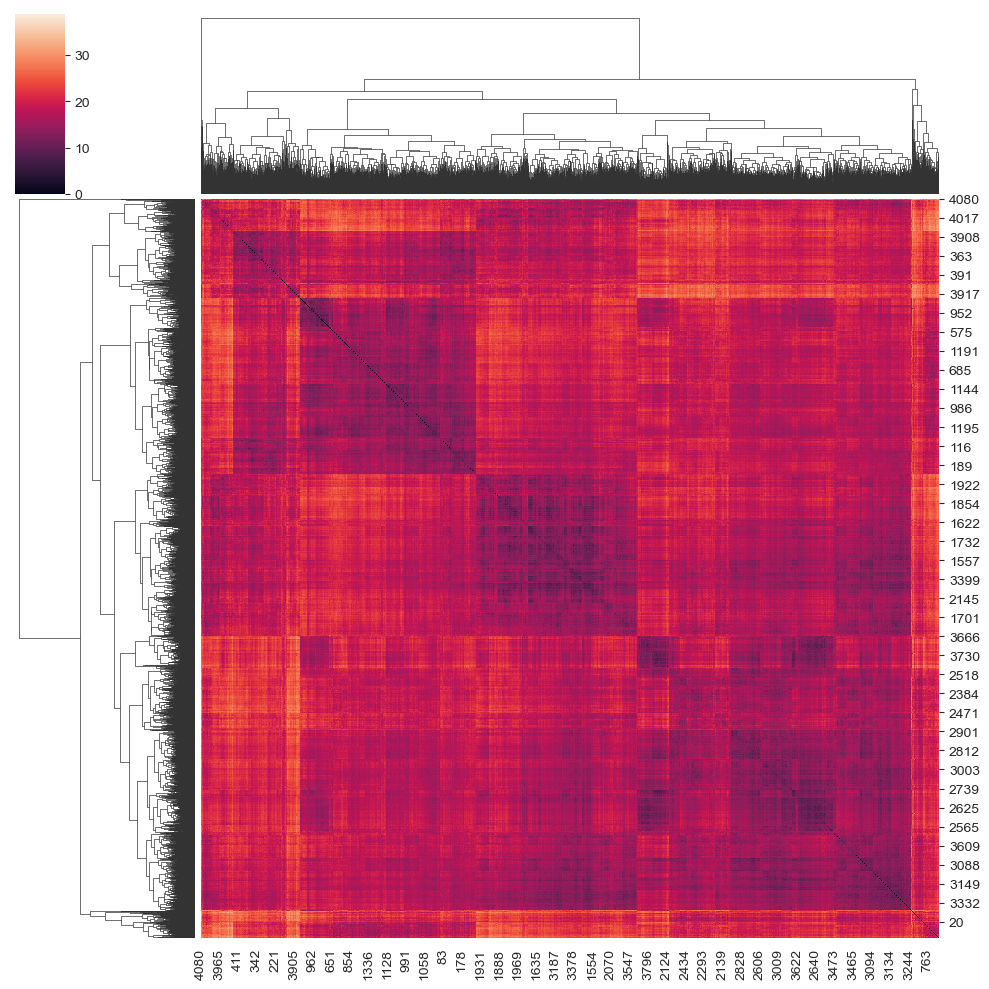

In [28]:
sns.clustermap(d)

## Silhouette scores

In [29]:
from sklearn.metrics import  silhouette_score

## Silhuette usando sklearn
silhouette_avg = silhouette_score(df, df_spotify.genre)
silhouette_avg

0.02787769837256899

In [30]:
from sklearn.metrics import  silhouette_samples

## Silhuette usando sklearn
sample_silhouette_values = silhouette_samples(df, df_spotify.genre)
sample_silhouette_values

array([ 0.00507581,  0.01952649,  0.08209464, ..., -0.05061537,
       -0.10346846, -0.00442912])

In [31]:
# Estimar el coeficiente de Silhouette para cada cluster
cluster_labels = df_spotify.genre
clusters = np.unique(cluster_labels)
ith_cluster_silhouette_avg = []
for cluster in clusters:
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster]
    ith_cluster_silhouette_avg.append(
        {
            "cluster": cluster,
            "silhouette_avg": np.mean(ith_cluster_silhouette_values)
        }
    )
ith_cluster_silhouette_avg

[{'cluster': 'ambient', 'silhouette_avg': -0.07451602031795874},
 {'cluster': 'classical', 'silhouette_avg': 0.00598604069979232},
 {'cluster': 'death-metal', 'silhouette_avg': 0.16730834150804086},
 {'cluster': 'drum-and-bass', 'silhouette_avg': -0.010423265001236966},
 {'cluster': 'jazz', 'silhouette_avg': 0.006092810865489151},
 {'cluster': 'opera', 'silhouette_avg': 0.10173629273608006},
 {'cluster': 'singer-songwriter', 'silhouette_avg': 0.013032979073434179},
 {'cluster': 'ska', 'silhouette_avg': 0.04015836713539744},
 {'cluster': 'trance', 'silhouette_avg': -0.01352498956249409}]

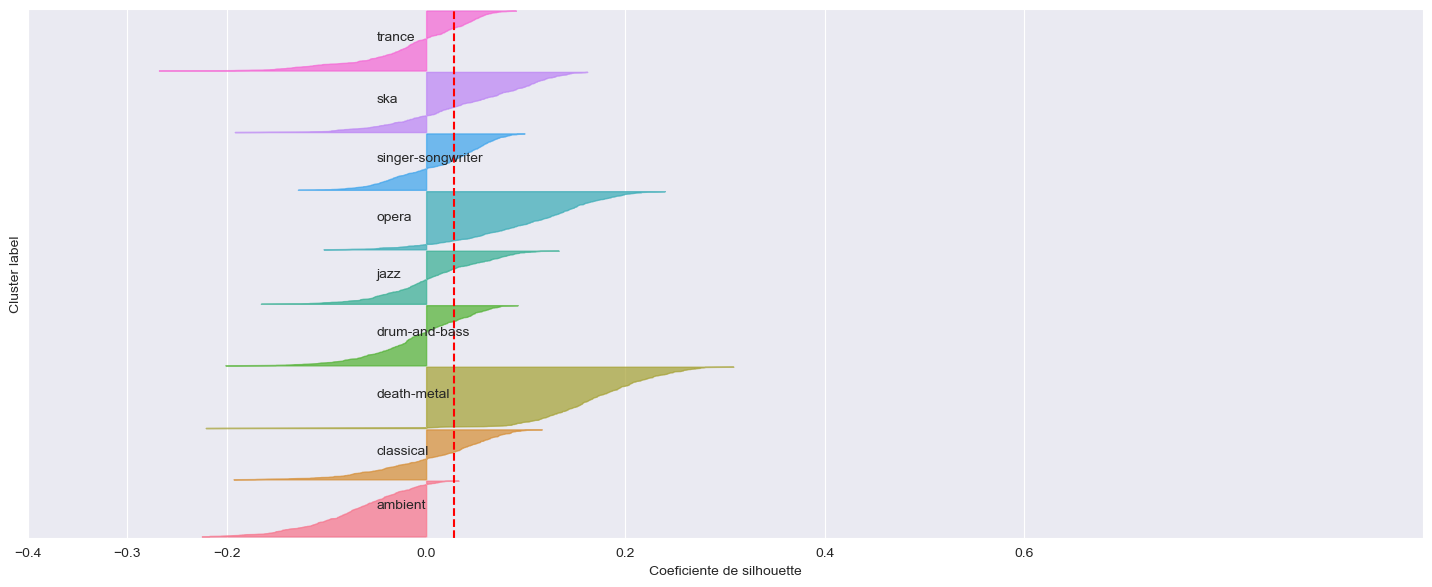

In [32]:
palette = iter(
    sns.husl_palette(
        len(clusters)
    )
)

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])

# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(df_spotify) + (len(clusters) + 1) * 10])

y_lower = 10
for cluster in clusters:
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == cluster]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = next(palette)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, cluster)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_xlabel("Coeficiente de silhouette")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(
    x=silhouette_avg,
    color="red",
    linestyle="--"
)

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.4, -0.3, -0.2, 0, 0.2, 0.4, 0.6])

plt.show()

## SSE